# Test Using BigQuery to Analyze DC2 Run 1.1p
Michael Wood-Vasey
Last Run: 2018-10-15

Demonstration Notebook of querying DC2 Run 1.1p Object Table as stored in Google Cloud BigQuery.

Data loading, and particularly calculations within the database are 10-20 faster than reading through flat files through NERSC or local laptop/desktop.

### Process

1. Store Parquet files in Google Cloud Storage Bucket using a test storage area (under my personal account:
    a. `dpdd_object_simple.parquet`
        -- 'simple' refers to the file_scheme.  Just one file instead of, e.g., a `Hive` format, which somewhat oddly, BigQuery doesn't offer to read.
    b. `dpdd_object_tract_4850.parquet`
        -- The per-tract files are in the 'simple' format.

These are the outputs of analyzing the DM Science Pipelines coadd+forced position photometry on images generated by PhoSim based on simulated input catalogs.

2. Load these files into BigQuery Table  using the Web BigQuery interface.

3. The data are stored in the `desc-dc2-wmwv` project

The BigQuery Table is
`desc-dc2-wmwv.run1p1p_object.run1p1p_object`

### Requirements
* `pip install google-cloud-bigquery`
* `pip install seaborn`

### Access
This Notebook was written as a demonstration / proof-of-concept.

I don't have any idea how to integrate with general DESC/NERSC identity management.  But as a shim for this, I've stored a Google API reader token at NERSC that is readable only to members of the `lsst` group.   The token is stored in

Authentication+Authorization Steps:
  - Created a Service Account
  - desc-dc2-reader 'Project->Reader'
  - Store JSON file with key.
  - Store location of JSON file in environment variable `GOOGLE_APPLICATION_CREDENTIALS`

References
* https://cloud.google.com/bigquery/docs/visualize-jupyter
* https://cloud.google.com/docs/authentication/getting-started
* https://googleapis.github.io/google-cloud-python/latest/bigquery/index.html

### Visualization
I was teaching myself Seaborn while writing this Notebook so the visualizations are in Seaborn.  We'll be doing things with dataframes so you could totally also use Holoviews+Datashader.

If you actually scatter plot each of the ~2 million points, that will take a minute or three just to plot.  The examples I'm doing here are all binning or otherwise aggregating quantities.

In [1]:
from google.cloud import bigquery

import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

Load iPython magic commands from the google.cloud.bigquery library

In [3]:
%load_ext google.cloud.bigquery

Set up environment that stores locastion of credentials:

In [51]:
import os

# If you're running at NERSC:
# API_TOKEN_DIR = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1p/object_catalog'

# If you're running locally:
API_TOKEN_DIR = './'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join(API_TOKEN_DIR, 'desc-dc2-wmwv-101be2d58cee.json')

### Calculate average g-r color:

There's not an obvious reason to do this, but it's what I was using as some simple performance testing in the `LSSTDESC/DC2-production` exploration of performance of difference data formats and access patterns.

1.8 seconds for calculating the average across 6 million records (6892380) is pretty good.  The same calculation reading from the flat files on NERSC takes 1 minute.

In [5]:
%%bigquery avg_g_r --verbose
SELECT AVG(mag_g - mag_r) FROM `desc-dc2-wmwv.run1p1p_object.run1p1p_object` 
WHERE 
magerr_g > 0 AND magerr_g < 0.3 AND
magerr_r > 0 AND magerr_r < 0.3 AND
magerr_i > 0 AND magerr_i < 0.3

Executing query with job ID: 4dba5d5f-e93a-43a2-a225-3bcbe21cce1a
Query executing: 0.49s
Query complete after 0.81s


,f0_
0,0.517273


The query takes ~3 seconds.

If we run it again it returns in less than a second because the answer is cached.

In [6]:
%%bigquery avg_g_r --verbose
SELECT AVG(mag_g - mag_r) FROM `desc-dc2-wmwv.run1p1p_object.run1p1p_object` 
WHERE 
magerr_g > 0 AND magerr_g < 0.3 AND
magerr_r > 0 AND magerr_r < 0.3 AND
magerr_i > 0 AND magerr_i < 0.3

Executing query with job ID: 3d246329-aa43-40c6-963c-63d88fbc2a45
Query executing: 0.43s
Query complete after 0.78s


,f0_
0,0.517273


In [7]:
%%bigquery bq_df --verbose
SELECT ra, dec, mag_g, mag_r, mag_i, magerr_g, magerr_r, magerr_i, extendedness 
FROM `desc-dc2-wmwv.run1p1p_object.run1p1p_object` 
WHERE 
magerr_g > 0 AND magerr_g < 0.3 AND
magerr_r > 0 AND magerr_r < 0.3 AND
magerr_i > 0 AND magerr_i < 0.3

Executing query with job ID: a1ef9882-8b85-4b66-88b7-7e4ea8424ecf
Query executing: 15.20s
Query complete after 15.56s


,ra,dec,mag_g,mag_r,mag_i,magerr_g,magerr_r,magerr_i,extendedness
0,53.660470,-29.890352,24.626811,23.808001,23.521704,0.081072,0.185169,0.106982,NaN
1,53.339895,-29.798619,25.420992,24.717886,24.579906,0.152534,0.256363,0.228785,NaN
2,55.186586,-30.486459,17.127035,19.745150,17.675648,0.001509,0.005693,0.001852,NaN
3,54.898489,-30.238683,17.877012,17.833656,17.666954,0.001945,0.001656,0.002003,NaN
4,54.515729,-30.845137,18.073920,18.650543,17.657975,0.002336,0.003347,0.002690,NaN
5,54.639543,-29.993820,17.905345,18.083641,17.694977,0.001850,0.002383,0.002485,NaN
6,55.415116,-30.299398,18.239725,18.013507,18.133500,0.002967,0.004111,0.003554,NaN
7,55.276523,-30.442705,17.218182,17.840306,17.526334,0.001613,0.002098,0.002370,NaN
8,53.841623,-29.932300,19.166045,20.052075,19.960654,0.005173,0.010396,0.008741,NaN
9,54.753397,-30.769765,23.105901,23.321337,23.231495,0.040446,0.085588,0.079015,NaN


The `%%bigquery --verbose` reports the time run the query, which is 15 seconds.

But it doesn't report the time to ship the data to the Jupyter kernel (which is local in this case), and create the `bq_df` dataframe.  This can take 1-3 minutes.

If you run the Notebook in the Google Cloud Datalab, then the kernel is in the Google Cloud.  In the Datalab creating the dataframe takes ~1 minute.

## Using the Python library explicitly:

The magic commands are an easy way to quickly do a query, but because it's a "magic" command it's not obvious what's happening.  Before reading the above, did you know that the `%%bigquery bq_df --verbose` magic command was going to create `bq_df` when it ran?

For programatic use, I would recommend explicitly using the Python library in the Client:

In [8]:
client = bigquery.Client()

In [9]:
sql = """
    SELECT ra, dec, mag_g, mag_r, mag_i, magerr_g, magerr_r, magerr_i, extendedness 
    FROM `desc-dc2-wmwv.run1p1p_object.run1p1p_object` 
    WHERE 
    magerr_g > 0 AND magerr_g < 0.3 AND
    magerr_r > 0 AND magerr_r < 0.3 AND
    magerr_i > 0 AND magerr_i < 0.3
"""

In [24]:
import time
t1 = time.time()
df = client.query(sql).to_dataframe()
t2 = time.time()
print("Query+dataframe creation took {:.2f} seconds", t2-t1)

Query+dataframe creation took {} 258.73288083076477


The above `client.query` command takes 1-3 minutes, which is comparable to the performance seen at NERSC on a single process.

In [35]:
df['g-r'] = df['mag_g'] - df['mag_r']
df['r-i'] = df['mag_r'] - df['mag_i']

In [12]:
len(df)

1896190

## Plotting

Plotting aggregated representations (bins, histograms, e.g.) is quite fast.  The data are all in memory now.

The below are all straight forward things to do once you have a dataframe with all of the columns you want.  They're here both as examples of visualizing these data, but also with the long-term idea of replacing the above simple query with a query that returns aggregated quantities sufficient to recreate the plots below:

#### A Bit of Housekeeping
Turn off `FutureWarning` messages
There are some SciPy warnings about reduce operations that are going to change in the future.

In [39]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

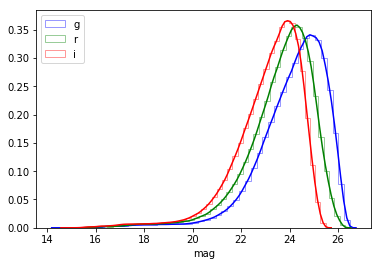

In [40]:
sns.distplot(df['mag_g'], label='g', color='blue', hist_kws={'histtype': 'step'})
sns.distplot(df['mag_r'], label='r', color='green', hist_kws={'histtype': 'step'})
sns.distplot(df['mag_i'], label='i', color='red', hist_kws={'histtype': 'step'})
plt.xlabel('mag')
plt.legend();

Now plot stars vs. galaxies.  This will be a conservative cut with a low false-positive for galaxies, but a significant false negative at lower SNR.

In [41]:
star = df[df['extendedness'] < 0.95]
gal = df[df['extendedness'] > 0.95]

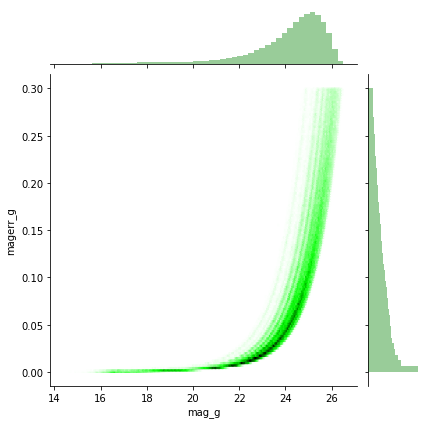

In [42]:
sns.jointplot(star['mag_g'], star['magerr_g'], label='"Stars"', color='green', kind='hexbin',
             gridsize=200);

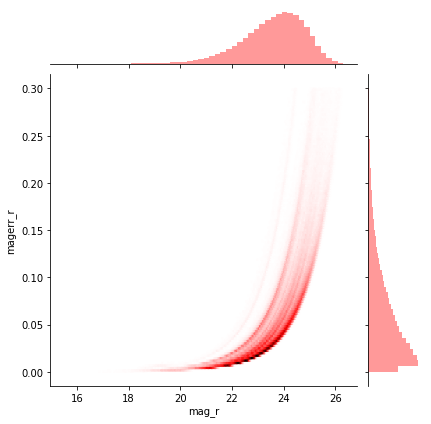

In [43]:
sns.jointplot(gal['mag_r'], gal['magerr_r'], label='Galaxies', color='red', kind='hexbin',
             gridsize=200);

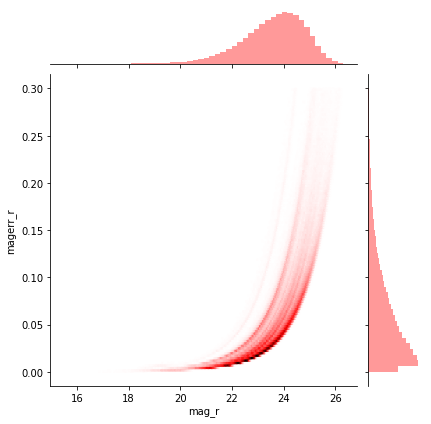

In [44]:
sns.jointplot(gal['mag_r'], gal['magerr_r'], label='Galaxies', color='red', kind='hexbin',
             gridsize=200);

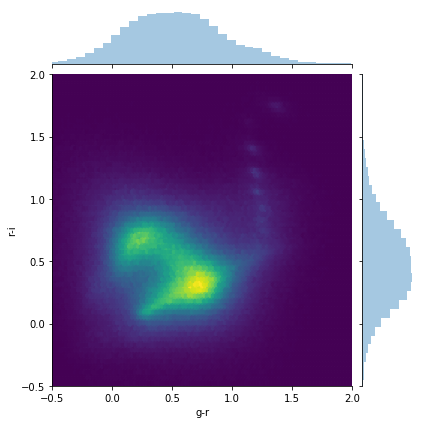

In [45]:
sns.jointplot(df['g-r'], df['r-i'], xlim=(-0.5, 2), ylim=(-0.5, 2),
              kind='hexbin', extent=(-0.5, 2, -0.5, 2), gridsize=100, cmap='viridis',
             marginal_kws={'bins': 201});

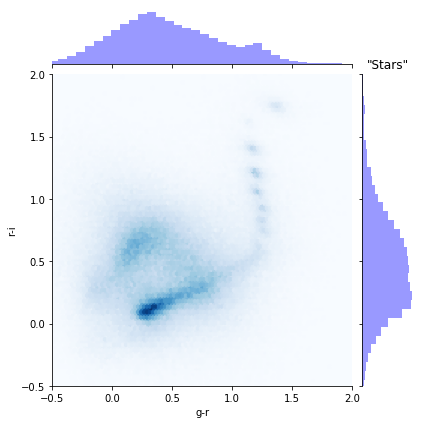

In [46]:
sns.jointplot(star['g-r'], star['r-i'], xlim=(-0.5, 2), ylim=(-0.5, 2),
              kind='hexbin', extent=(-0.5, 2, -0.5, 2), gridsize=100, cmap='Blues',
              marginal_kws={'color': 'blue', 'bins': 201})
plt.title('"Stars"');

Note the clean stellar locus plus additional contamination from galaxies not identified as clearly extended.  The stellar locus model has a set of discrete types for M, L dwarfs.

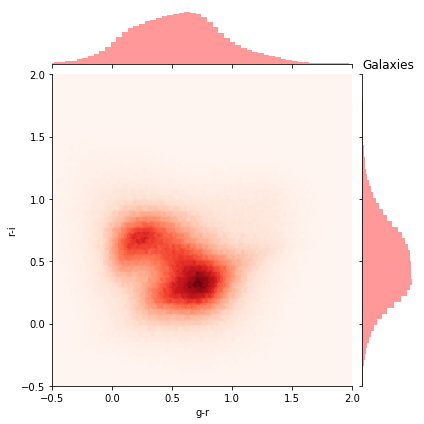

In [47]:
sns.jointplot(gal['g-r'], gal['r-i'], xlim=(-0.5, 2), ylim=(-0.5, 2),
              kind='hexbin', gridsize=100, extent=(-0.5, 2, -0.5, 2), cmap='Reds',
              marginal_kws={'color': 'red', 'bins': 201})
plt.title('Galaxies');

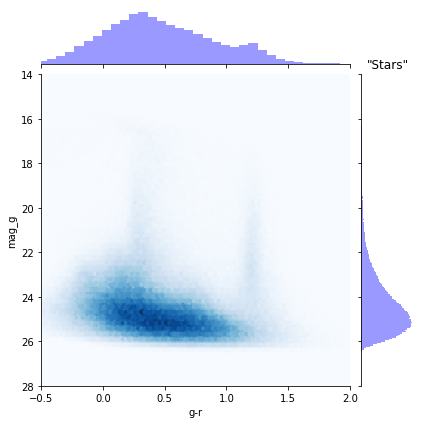

In [48]:
sns.jointplot(star['g-r'], star['mag_g'], xlim=(-0.5, 2), ylim=(28, 14),
           kind='hexbin', gridsize=100, extent=(-0.5, 2, 28, 14), cmap='Blues',
           marginal_kws={'color': 'blue', 'bins': 201},
           label='"Stars"')
plt.title('"Stars"');

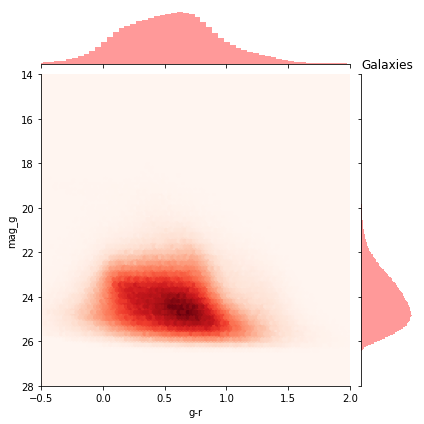

In [49]:
sns.jointplot(gal['g-r'], gal['mag_g'], xlim=(-0.5, 2), ylim=(28, 14),
           kind='hexbin', gridsize=100, extent=(-0.5, 2, 28, 14), cmap='Reds',
           marginal_kws={'color': 'red', 'bins': 201},
           label='Galaxies')
plt.title('Galaxies');

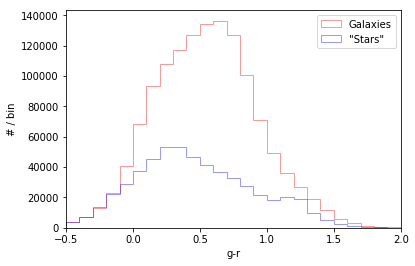

In [50]:
hist_kwargs = {'norm_hist': False, 'bins': np.linspace(-1, 2, 31), 'kde': False, 'hist_kws': {'histtype': 'step'}}

sns.distplot(gal['g-r'], label='Galaxies', color='red', **hist_kwargs)
sns.distplot(star['g-r'], label='"Stars"', color='blue',  **hist_kwargs)
plt.xlim(-0.5, 2)
plt.xlabel('g-r')
plt.ylabel('# / bin')

plt.legend();